In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import torch
from torch.distributions import *
from scipy.special import beta as B
from scipy.special import gamma as Gam
from scipy.special import digamma

In [26]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd My\ Drive
%cd Colab\ Notebooks

vocab = open('vocab.txt', 'r')
vocab = [line.rstrip() for line in vocab.readlines()]

V = len(vocab)

data = open('ap.dat', 'r')
data = [line.rstrip() for line in data.readlines()]

N = len(data)

doc_counts = np.zeros((N, V))

for i, datum in enumerate(data):
  counts = datum.split(" ")[1:]
  for count in counts:
    idx, ct = [int(_) for _ in count.split(":")]
    doc_counts[i, idx] = ct

df = pd.DataFrame(columns=vocab, data=doc_counts)
print (df.shape)

word_counts = df.values.sum(axis=0)
print (word_counts)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks
(2246, 10473)
[2073. 2014. 1949. ...    6.    6.    6.]


In [0]:
test = torch.arange(1, 17).reshape(4, 4).type(torch.float)

print (test)

# print (test[:, 2:])

# print (test[:, 2:].sum(axis = 1))

# print (test[1, :])

# print (test.mean(axis=0))

print ([1,2,3][:2])

print (test.max())

test = torch.tensor([1, 1, 1, 5, 5, 5, 3, 10])

_, un = test.unique(return_counts=True)

# print (un)

tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.]])
[1, 2]
tensor(16.)
tensor([ 1,  1,  1,  5,  5,  5,  3, 10])


IndexError: ignored

In [0]:
# Inference

# Gamma prior on the rates (G_0 is a Gamma with params lambda_0, lambda_1)

def z_init(N, alpha):
    '''
    Initializes a random vector of cluster assignments
    '''
    z = torch.zeros(N)
    counts = [1] 
    for i in range(1, N):
        weights = torch.tensor([count / (i+alpha) for count in counts] + [alpha / (i+alpha)])
        new_z = Categorical(weights).sample()
        z[i] = new_z
        if new_z > len(counts) - 1:
          counts.append(1)
        else:
          counts[new_z] += 1
    
    return z

def z_conditional(Z, alpha):
    '''
    Input:
      Z - (t,) tensor consisting of the past t many cluster assignments (should it contain all cluster assignments aside from the current one?)
      alpha - scaling hyperparameter
    '''

    K = Z.max() # total number of clusters (at current step)
    N = Z.shape[0]
    _, counts = Z.unique(return_counts=True)
    weights = torch.tensor([count / (N+alpha) for count in counts] + [alpha / (N+alpha)])
    return Categorical(weights).sample()

def eta_conditional(Z, X, k, lmbda):
    '''
    Input:
      Z - (N,) tensor consisting of all cluster assignments
      X - (N,) tensor consisting of all observations
      k - the number of the cluster for which we are sampling cluster parameters
      lbmda - (2,) tensor of Gamma hyperparameters
    '''

    N = Z.shape[0]
    cluster_obs = [X[i] for i in range(N) if Z[i] == k]
    return Gamma(lmbda[0] + sum(cluster_obs), lmbda[1] + len(cluster_obs)).sample()


alpha = torch.tensor([1.5])
lmbda = torch.tensor([1., 1.])

N = word_counts.shape[0]
X = torch.tensor(word_counts, dtype=torch.float)

num_iter = 1000

z = z_init(N, alpha)
eta = Gamma(lmbda[0], lmbda[1]).sample([int(z.max().item())])

z_t = []
eta_t = []
for iteration in tqdm(range(num_iter)):
    z_new = torch.zeros(N)
    z_new[0] = 0
    
    for i in range(1, N):
        z_new[i] = z_conditional(z[:i], alpha) 
    
    K = int(z_new.max().item()) + 1
    eta_new = torch.zeros(K)
    
    for j in range(K):
        eta_new[j] = eta_conditional(z_new, X, j, lmbda)

    z_t.append(z_new)
    eta_t.append(eta_new)

    z = z_new
    eta = eta_new


In [32]:
def get_weights(Z, alpha):
    N = Z.shape[0]
    _, counts = Z.unique(return_counts=True)
    weights = torch.tensor([count / (N+alpha) for count in counts])
    return weights / weights.sum()

for i in range(100, len(z_t), 50):
    print (get_weights(z_t[i], alpha))
    print (eta_t[i])

max_clusters = int(torch.tensor([len(eta_i) for eta_i in eta_t]).max())

Bayes_Weights = torch.zeros(max_clusters)
Bayes_Rates = torch.zeros(max_clusters)

for i in range(100, len(z_t), 50):
    print (get_weights(z_t[i], alpha))
    print (eta_t[i])


Bayes_Weights = get_weights(z_t[-1], alpha)
Bayes_Rates = eta_t[-1]

tensor([2.7776e-01, 2.3613e-01, 2.7490e-01, 1.0809e-01, 5.5858e-02, 1.8142e-02,
        1.2699e-02, 5.7290e-03, 4.8697e-03, 2.7690e-03, 7.6387e-04, 1.1458e-03,
        5.7290e-04, 9.5484e-05, 1.9097e-04, 2.8645e-04])
tensor([38.4035, 44.3460, 44.1718, 32.3409, 51.6668, 45.4772, 49.9855, 35.2756,
        39.1913, 34.2556, 23.2496, 22.3077, 11.7856,  2.6196, 10.9405,  8.4215])
tensor([2.8425e-01, 3.5119e-01, 1.2948e-01, 1.2002e-01, 6.9130e-02, 3.1605e-02,
        6.7793e-03, 4.0103e-03, 1.6232e-03, 9.5484e-04, 1.9097e-04, 2.8645e-04,
        2.8645e-04, 1.9097e-04])
tensor([40.8362, 38.2124, 51.4427, 42.7090, 40.3588, 36.9240, 70.5145, 76.1036,
        32.3257, 21.2538, 30.6134, 16.7789,  9.3872,  0.2684,  4.7371])
tensor([0.3805, 0.3053, 0.0970, 0.1011, 0.0433, 0.0339, 0.0242, 0.0069, 0.0034,
        0.0024, 0.0007, 0.0005, 0.0004, 0.0005])
tensor([40.4982, 44.5990, 44.7049, 37.6759, 33.9669, 49.2365, 25.3777, 45.7411,
        51.3825, 24.9115, 64.4509, 26.3446, 10.5308, 21.9124])
tenso

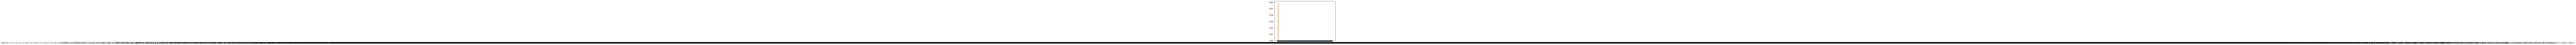

In [34]:
Samples = torch.arange(0, 300).type(torch.float)

def mix_of_Poisson(weights, rates, samples):
  return sum( [weights[i] * np.exp(Poisson(rates[i]).log_prob(samples)) for i in range(len(weights))] )


Y = mix_of_Poisson(Bayes_Weights, Bayes_Rates, Samples)
plt.hist(data, bins=40, density=True, lw=0, alpha=0.75);
plt.plot(Samples, Y)
plt.show()